In [1]:
# First we want to load in a halo catalog

import sys
sys.path.append('../../skyLine//')
#sys.path.append('/home/users/kokron/Libraries/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu

from SkyLine import make_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import time
import healpy as hp
from scipy.optimize import root_scalar

# palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)

color1='#d1a862'
color2='#c38854'
color3='#9c4630'
color4='#550022'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [color1,color2,color3,color4])


plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.facecolor'] = 'w'

LC_path = '/home/jlbernal/Data/MDPL2_lightcone/400deg2/'
#LC_path='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lightcone_square/'
# LC_path='/oak/stanford/orgs/kipac/users/kokron/MDPL2-UM/lc_fullsky'

In [2]:
def LC_params(line):
    '''
    This function is a proxy to return a dictionary with the input parameters to call SkyLine. 
    
    This function it's designed to get the same noise, resolution and redshift coverage for all lines, 
    but serves as an example for any application
    '''
    h=0.678 #Reduced Hubble constant from the lightcone. This is default, used here for h-based units
    
    #survey and experimental parameters
    zmin = 0.8;zmax = 1.0 #minimum and maximum redshift of the survey (to load lightcone slices)
    zmid=(zmax+zmin)/2 #mid redshift
    R=700 # Spectral Resolution
    ang_lim=2*u.deg #RA and DEC (total) width of the survey
    
    #line-dependent parameters
    if line=='CO':
        nu_CO=115.271*u.GHz #rest-frame frequency
        dnu=nu_CO/(1+zmid)/R #channel witdh for this case
        nuObs_max, nuObs_min = nu_CO/(1+zmin), nu_CO/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(CO_J10=True) 
        target_line = 'CO_J10'
        line_models = dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                     model_pars={'alpha':0.674,'beta':4.898,'alpha_std':0,'beta_std':0,'sigma_L':0.2})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = False
        Tsys=0*u.uK #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity   
    
    #Create the dictionary and fill it. 
    params=dict(halo_lightcone_dir=LC_path, #specify the path to the directory with the lightcone slices
                do_external_SFR = False, external_SFR = '', SFR_pars=dict(), #we use UniverseMachine SFRs, but you can input your own! Check source/external_sfrs.py 
                #which halos to load?
                zmin = zmin-0.03, zmax = zmax+0.03, #limits to load the lightcone slices. Small overhead to avoid border effects or not including a given slice..
                RA_width=ang_lim, DEC_width=ang_lim, #limits in DEC and RA width to load halos from the lightcone
                #Build the survey (line-related parameters defined above)
                lines = lines, #lines included in the survey
                target_line = target_line, #target line: used to set the redshift (interlopers define with respect to this)
                models = line_models, #models for the lines included
                LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10), #infrared luminoisity model
                do_intensity = do_intensity, #using intensity or brightness temperature?
                do_remove_mean=True, #We can't measure the mean temperature -> removed from sky subtraction
                RAObs_width=ang_lim, DECObs_width=ang_lim, #limits in DEC and RA width for the survey
                nuObs_max= nuObs_max,nuObs_min =nuObs_min, #The edges of the bandwith of the experiment
                #experimental noise and resoultion
                Nfeeds=1000, #number of detectors
                tobs=6000*u.hr, # total observing time
                dnu = dnu, #channel width
                beam_FWHM=2*u.arcmin, #beam FWHM 
                #do you want to apply the smoothing kernels to mock experimental resolution?
                do_angular_smooth=True, do_spectral_smooth=True,
                # precision parameters
                resampler='cic', #mass asignment filter
                angular_supersample=4, spectral_supersample=4, #angular and spectral supersample (with respect to the experimental resolutions in physical)
                do_downsample=True, # do you want to downsample back to 1 voxel / resolution element (after smoothing by the experimental resolution kernels)
                cube_mode='inner_cube', #how do you want so cut your observed cube. Inner_cube is the safest for now
                Nmu=30, #Number of bins in mu = k/k_par to compute the power spectrum multipoles
                dk=0.02*u.Mpc**-1, # bin size in the k vector for the power spectrum
                kmin=0.*u.Mpc**-1,kmax=1*u.Mpc**-1, #min and max k value for the power spectrum
                seed=0) #seed for the RNG. 
                
    return params

In [3]:
def LC_params_cib():
    '''
    This function is a proxy to return a dictionary with the input parameters to call SkyLine. 
    
    This function it's designed to get the same noise, resolution and redshift coverage for all lines, 
    but serves as an example for any application
    '''
    h=0.678 #Reduced Hubble constant from the lightcone. This is default, used here for h-based units
    
    #survey and experimental parameters
    zmin = 0.8;zmax = 1.0 #minimum and maximum redshift of the survey (to load lightcone slices)
    zmid=(zmax+zmin)/2 #mid redshift
    R=700 # Spectral Resolution
    ang_lim=20*u.deg #RA and DEC (total) width of the survey
    
    #line-dependent parameters
    if line=='CO':
        nu_CO=115.271*u.GHz #rest-frame frequency
        dnu=nu_CO/(1+zmid)/R #channel witdh for this case
        nuObs_max, nuObs_min = nu_CO/(1+zmin), nu_CO/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(CO_J10=True) 
        target_line = 'CO_J10'
        line_models = dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                     model_pars={'alpha':0.674,'beta':4.898,'alpha_std':0,'beta_std':0,'sigma_L':0.2})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = False
        Tsys=0*u.uK #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity   
    
    #Create the dictionary and fill it. 
    params=dict(halo_lightcone_dir=LC_path, #specify the path to the directory with the lightcone slices
                do_external_SFR = False, external_SFR = '', SFR_pars=dict(), #we use UniverseMachine SFRs, but you can input your own! Check source/external_sfrs.py 
                #which halos to load?
                zmin = zmin-0.03, zmax = zmax+0.03, #limits to load the lightcone slices. Small overhead to avoid border effects or not including a given slice..
                RA_width=ang_lim, DEC_width=ang_lim, #limits in DEC and RA width to load halos from the lightcone
                #Build the survey (line-related parameters defined above)
                mode = 'cib', #lines included in the survey
                target_line = target_line, #target line: used to set the redshift (interlopers define with respect to this)
                models = line_models, #models for the lines included
                LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10), #infrared luminoisity model
                do_intensity = do_intensity, #using intensity or brightness temperature?
                do_remove_mean=True, #We can't measure the mean temperature -> removed from sky subtraction
                RAObs_width=ang_lim, DECObs_width=ang_lim, #limits in DEC and RA width for the survey
                nuObs_max= nuObs_max,nuObs_min =nuObs_min, #The edges of the bandwith of the experiment
                #experimental noise and resoultion
                Nfeeds=1000, #number of detectors
                tobs=6000*u.hr, # total observing time
                dnu = dnu, #channel width
                beam_FWHM=2*u.arcmin, #beam FWHM 
                #do you want to apply the smoothing kernels to mock experimental resolution?
                do_angular_smooth=False, do_spectral_smooth=False,
                # precision parameters
                resampler='cic', #mass asignment filter
                angular_supersample=1, spectral_supersample=1, #angular and spectral supersample (with respect to the experimental resolutions in physical)
                do_downsample=True, # do you want to downsample back to 1 voxel / resolution element (after smoothing by the experimental resolution kernels)
                cube_mode='inner_cube', #how do you want so cut your observed cube. Inner_cube is the safest for now
                Nmu=30, #Number of bins in mu = k/k_par to compute the power spectrum multipoles
                dk=0.02*u.Mpc**-1, # bin size in the k vector for the power spectrum
                kmin=0.*u.Mpc**-1,kmax=1*u.Mpc**-1, #min and max k value for the power spectrum
                seed=0) #seed for the RNG. 
                
    return params

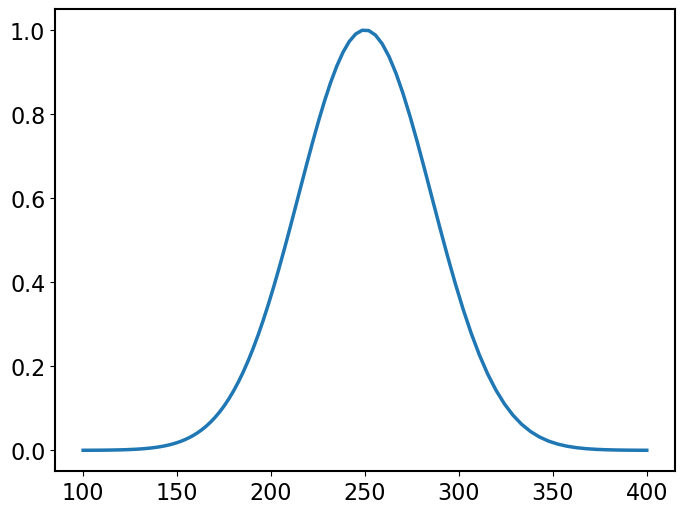

In [4]:
nu0 = np.logspace(2,np.log10(400),100)*u.GHz
tau_nu = np.exp(-(nu0.value-0.5*(nu0.value[-1]+nu0.value[0]))**2/(50)**2)*u.GHz**-1
plt.plot(nu0,tau_nu)
MM = np.zeros((len(nu0),2))
MM[:,0] = nu0
MM[:,1]= tau_nu
np.savetxt('tau_nu_test.txt',MM)

In [6]:
nside = 512
dz = 0.1
LC_CO = make_measurements(LC_params('CO'))
LC_CO.update(LIR_pars=dict(IRX_name='Bouwens2020', log10Ms_IRX=9.63, alpha_IRX=1.37, sigma_IRX=0.2,
            K_IR=1.38e-10, K_UV=1.53e-10),CIB_pars=dict(A_d=33.96,B=-2.3,zeta_d=1.25,alpha=-2.31),
            do_angular=True,angular_map=True,nside = 512,mode='cib',spectral_transmission_file='tau_nu_test.txt',nuObs_min=100*u.GHz,nuObs_max=400*u.GHz)

/home/jlbernal/Code/skyLine/notebooks/../../skyLine/source/utilities.py:184: UserWarning: The line CO_J10 on the bandwidth [400.00 GHz,100.00 GHz] corresponds to z range [-0.71,0.15], while the included redshifts in the lightcone are within [0.77,1.03]. Please remove the line, increase the zmin,zmax range or reduce the bandwith.
  warn('The line {} on the bandwidth [{:.2f},{:.2f}] corresponds to z range [{:.2f},{:.2f}], while the included redshifts in the lightcone are within [{:.2f},{:.2f}]. Please remove the line, increase the zmin,zmax range or reduce the bandwith.'.format(line,self.nuObs_max,self.nuObs_min,zlims[0],zlims[1],self.zmin,self.zmax))
/home/jlbernal/Code/skyLine/notebooks/../../skyLine/source/utilities.py:191: UserWarning: The minimum NSIDE to account for beam_FWHM*angular_supersample is 8192, but NSIDE=512 was input.
  warn("The minimum NSIDE to account for beam_FWHM*angular_supersample is {}, but NSIDE={} was input.".format(min_nside,self.nside))


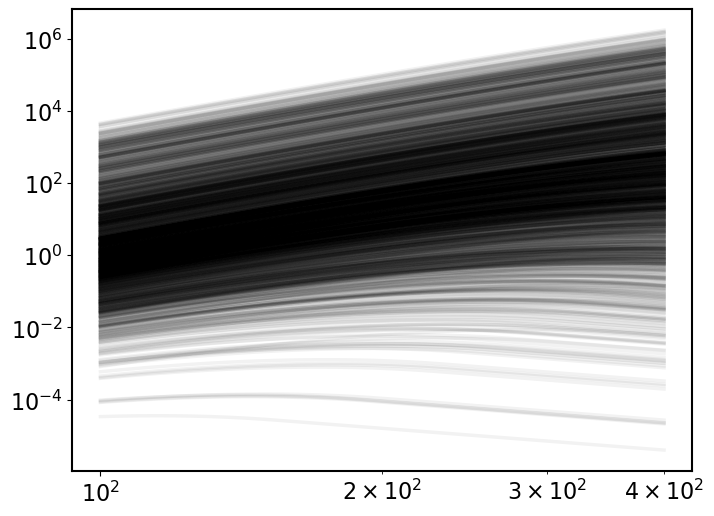

In [7]:
ma = LC_CO.obs_2d_map

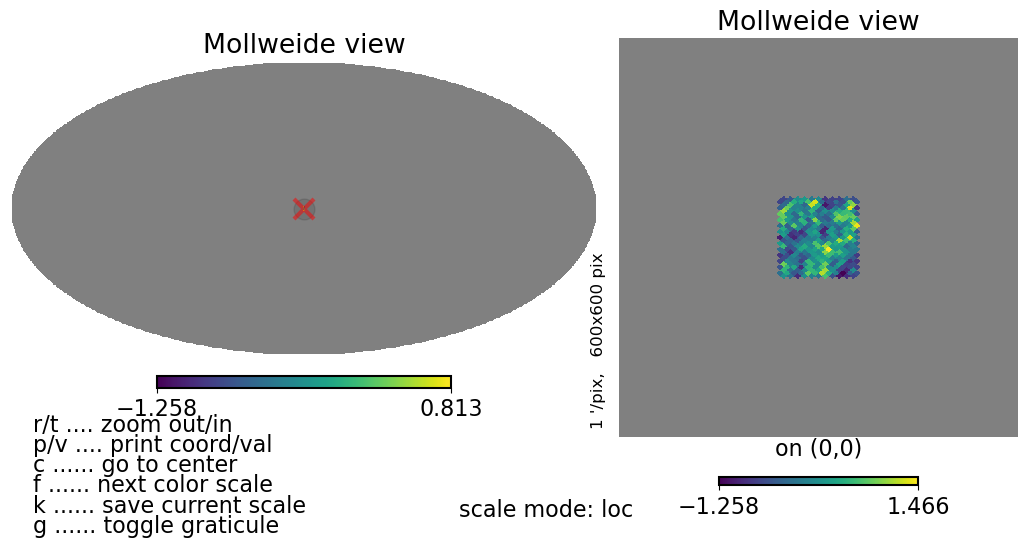

In [17]:
hp.mollzoom(ma)

In [11]:
np.ones(3,dtype=bool)

array([ True,  True,  True])

In [7]:
import source.line_models as LM

In [9]:
LIR = getattr(LM,'LIR')(LC_CO,LC_CO.halos_in_survey_all['SFR'],LC_CO.halos_in_survey_all['Mstar'],LC_CO.LIR_pars,LC_CO.rng)

KeyError: 'SFR'

In [10]:
LC_CO.mode

'lim'

In [8]:
nside = 512
dz = 0.1
LC_CO = make_measurements(LC_params('CO'))

#We take the middle channel for now as nu for SED?
nu_sed = LC_CO.nuObs_mean

#
z_sed = LC_CO.zmid

def Zgas(halocat):
    '''
    Computes the gas metallicity of each halo in the catalog
    
    '''
    inds = (halocat['SFR_HALO']>0)&(halocat['SM_HALO']>0)
    mstars = halocat['SM_HALO']
    
    sfrs = halocat['SFR_HALO']
    
    y = np.log10(mstars) - 0.6 * np.log10(sfrs) - 10

    zgas = np.zeros_like(sfrs)
    zgas[inds] = 8.80 + 0.188*y[inds] - 0.220 * y[inds]**2 - 0.0531 * y[inds] ** 3
    
    return zgas

def mainsequence_ssfr(halocat):
    '''
    Computes the main sequence specific star formation rate for each halo. 
    This requires an implementation of "cosmic time" given z 
    
    defined in page 3 of https://browse.arxiv.org/pdf/1702.01140.pdf
    
    Note there is a difference of 10^9 because we convert our sSFR to Yr^-1 and
    theirs are in Gyr^-1.
    
    '''
    
    logz = np.log10(1 + halocat['Z'])
    
    #Get cosmic time of each halo for this specific calibrated fit
    logtc = 1.143 - 1.026 * logz - 0.599 * logz**2 + 0.528 * logz**3
    
    tc = 10**logtc

    inds = halocat['SM_HALO']>0
    logmstar = np.log10(halocat['SM_HALO'])

    log10ssfr = np.zeros_like(logz)
    log10ssfr[inds] = (-0.16 - 0.026*tc[inds]) * (logmstar[inds] + 0.025) - (6.51 - 0.11*tc[inds]) 
    
    res = np.zeros_like(log10ssfr)
    res[inds] = 10**log10ssfr[inds]
    return res

def MgasToMstar(halocat):
    '''
    Gas-to-stellar mass ratio for a halo with SFR and SM
    '''
    A = 0.06
    B = -2.30
    F = 0.65
    C = 0.51
    D = -0.41
    
    ms_ssfr = mainsequence_ssfr(halocat)

    inds = (ms_ssfr>0)&(halocat['SM_HALO']>0)
    ssfr = halocat['SFR_HALO']/halocat['SM_HALO']

    Delta_MS = np.zeros_like(ms_ssfr)
    Delta_MS[inds] = ssfr[inds] / ms_ssfr[inds]

    log10mgas = np.zeros_like(Delta_MS)
    log10mgas[inds] = A + B * (np.log10(1 + halocat['Z'][inds]) - F)**2 + C*np.log10(Delta_MS[inds]) + D*(np.log10(halocat['SM_HALO'][inds]) - 10.7)

    res = np.zeros_like(Delta_MS)
    res[inds] = 10**log10mgas[inds]
    return res

def fz(halocat):
    '''
    Computes the redshift dependent suppression of dust to stellar mass
    
    f(z) = {1 if z < 2
            (1 - 0.05*z)^alpha if z >=2 }
    where the best fit alpha is -2.31
    '''
    alpha = -2.31
    
    zs = halocat['Z']
    
    farr = np.ones_like(zs)
    
    zidx = np.where(zs > 2)
    
    
    farr[zidx] = (1 - 0.05*zs[zidx])**alpha
    
    return farr
    
def Mdust(halocat):
    '''
    What is the normalization here?? Eqn 7 in the draft is a \propto
    
    '''
    ratio = MgasToMstar(halocat)
    zgas = Zgas(halocat)
    
    
    fzs = fz(halocat)
    
    Mdust = halocat['SM_HALO'] * ratio* zgas * fzs
    
    return Mdust

def efe(x,lir,mdust):
    D = lir/mdust
    zeta_d = 1.25
    C = 33.96
    A,B = 125*zeta_d,125*0.4
    return A/x - B - C*D**(1/(4+x))

def efe_prime(x,lir,mdust):
    D = lir/mdust
    zeta_d = 1.25
    C = 33.96
    A,B = 125*zeta_d,125*0.4
    return C*D**(1/(4+x))*np.log(D)/(x+4)**2-A/x**2

def my_newton(lir,mdust,x0,Niter=5):
    for i in range(Niter):
        x0 = x0 - efe(x0,lir,mdust)/efe_prime(x0,lir,mdust)
    return x0

def SED(nu,Tdust,beta_d):
    alpha_d = 2
    kTh = (cu.k_B*Tdust/(cu.h)).to(u.GHz)
    nup = kTh*(3+beta_d+alpha_d)
    Phi = np.zeros_like(nu.value)
    nulim = np.arange(len(nu))[nu>nup][0]
    Phi[:nulim] = nu[:nulim].value**(beta_d+3)/np.exp((nu[:nulim]/kTh).decompose())
    Phi[nulim:] = nup.value**(beta_d+3)/np.exp((nup/kTh).decompose())*(nu[nulim:]/nup)**-alpha_d
    return Phi

def SED_array(nu,Tdust,beta_d):
    alpha_d = 2
    kTh = (cu.k_B*Tdust/(cu.h)).to(u.GHz)
    nup = kTh*(3+beta_d+alpha_d)
    Phi = nu.value**(beta_d[None,:]+3)/np.exp((nu/kTh[None,:]).decompose())
    inds = nu > nup
    Phi[inds] = (nup[None,:].value**(beta_d[None,:]+3)/np.exp((nup/kTh[None,:]).decompose())*(nu/nup[None,:])**-alpha_d)[inds]
    return Phi
    
def SED_args(halocat,lir):
    mdust = Mdust(halocat)
    Ad = 33.96
    inds = (lir>0)&(mdust>0)

    beta_d = my_newton(lir[inds].value,mdust[inds],2.5,Niter=5)
    Tdust = Ad * (lir[inds].value/mdust[inds])**(1/(4+beta_d))

    return Tdust*u.K,beta_d

def SEDnorm(Tdust,beta_d):
    alpha_d = 2
    kTh = (cu.k_B*Tdust/(cu.h)).to(u.GHz)
    nup = kTh*(3+beta_d+alpha_d)
    return kTh.value**(4+beta_d)*sp.gamma(4+beta_d)*sp.gammainc(4+beta_d,3+alpha_d+beta_d) + nup.value**(4+beta_d)/(alpha_d-1)/np.exp(3+alpha_d+beta_d)



In [9]:
LC_CO.halo_slices(0.8,1)

array(['/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_80.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_81.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_82.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_83.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_84.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_85.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_86.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_87.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_88.fits',
       '/home/jlbernal/Data/MDPL2_lightcone/400deg2/lightcone_MDPL2UM_89.fits'],
      dtype='<U69')

In [10]:
sys.path.append('../../skyLine/source/')

from line_models import LIR, lines_included

In [11]:
seed = 0

rng = np.random.default_rng(seed)

#Taking values from Yuuki's paper
LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.63, alpha_IRX=1.37, sigma_IRX=0.2,
            K_IR=1.38e-10, K_UV=1.53e-10)

LIRvec = LIR([], LC_CO.halo_catalog_all['SFR_HALO'], LC_CO.halo_catalog_all['SM_HALO'], LIR_pars, rng)

In [7]:
LC_CO.halo_catalog_all['SFR_HALO']

array([1.2273095 , 0.        , 0.        , ..., 0.01033651, 0.00322508,
       0.07145258], dtype=float32)

In [8]:
LC_CO.L_line_halo_all

{'CO_J10': <Quantity [1.24942636e+03, 0.00000000e+00, 0.00000000e+00, ...,
            6.21230922e-04, 6.00051243e-05, 8.94199241e-01] solLum>}

In [9]:
logSFR=np.linspace(-1,2,30)
logsfrcat = np.log10(LC_CO.halo_catalog_all['SFR_HALO'])
meanLIR=[]
medianLIR=[]
for i in range(len(logSFR)-1):
    inds = (logsfrcat>=logSFR[i])&(logsfrcat<logSFR[i+1])&(np.log10(LC_CO.halo_catalog_all['SFR_HALO'])>0)
    lir = np.log10(LIRvec[inds].value)
    meanLIR.append(np.mean(lir)) 
    medianLIR.append(np.median(lir))

meanLIR = np.asarray(meanLIR)
medianLIR = np.asarray(medianLIR)


/tmp/ipykernel_14688/2137684607.py:2: RuntimeWarning: divide by zero encountered in log10
  logsfrcat = np.log10(LC_CO.halo_catalog_all['SFR_HALO'])
/tmp/ipykernel_14688/2137684607.py:6: RuntimeWarning: divide by zero encountered in log10
  inds = (logsfrcat>=logSFR[i])&(logsfrcat<logSFR[i+1])&(np.log10(LC_CO.halo_catalog_all['SFR_HALO'])>0)
/home/jlbernal/anaconda3/envs/pmesh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jlbernal/anaconda3/envs/pmesh/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
binlogsfr = 0.5*(logSFR[1:]+logSFR[:-1])

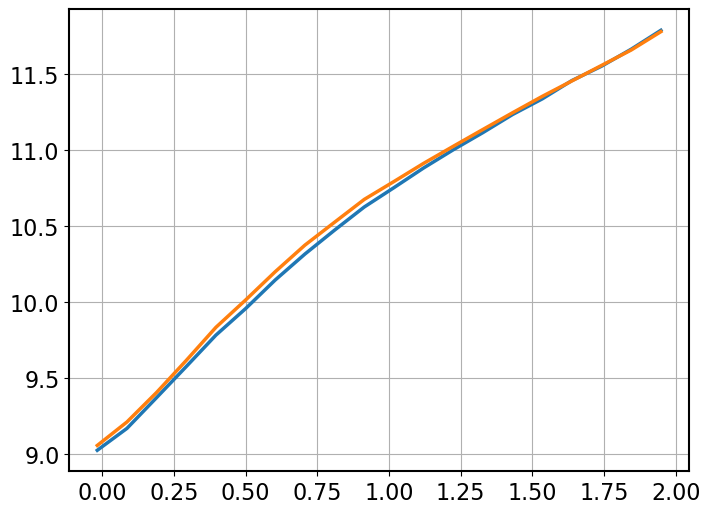

In [11]:
plt.plot(binlogsfr,(meanLIR))
plt.plot(binlogsfr,(medianLIR))
plt.grid()

In [12]:
mdust = Mdust(LC_CO.halo_catalog_all)

/tmp/ipykernel_14688/1060820771.py:48: RuntimeWarning: divide by zero encountered in log10
  logmstar = np.log10(halocat['SM_HALO'])
/tmp/ipykernel_14688/1060820771.py:70: RuntimeWarning: invalid value encountered in divide
  ssfr = halocat['SFR_HALO']/halocat['SM_HALO']
/tmp/ipykernel_14688/1060820771.py:21: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(mstars) - 0.6 * np.log10(sfrs) - 10
/tmp/ipykernel_14688/1060820771.py:21: RuntimeWarning: invalid value encountered in subtract
  y = np.log10(mstars) - 0.6 * np.log10(sfrs) - 10


In [13]:
ms_ssfr = mainsequence_ssfr(LC_CO.halo_catalog_all)

/tmp/ipykernel_14688/1060820771.py:48: RuntimeWarning: divide by zero encountered in log10
  logmstar = np.log10(halocat['SM_HALO'])


In [14]:
def analytic_msssfr(Mstar, z=3):
    
    logz = np.log10(1 + z)
    
    #Get cosmic time of each halo for this specific calibrated fit
    logtc = 1.143 - 1.026 * logz - 0.599 * logz**2 + 0.528 * logz**3
    
    tc = 10**logtc
    
    logmstar = np.log10(Mstar)
    
    log10ssfr = (-0.16 - 0.026*tc) * (logmstar + 0.025) - (6.51 - 0.11*tc) 
    
    return log10ssfr

In [15]:
inds = LC_CO.halo_catalog_all['SM_HALO']>0

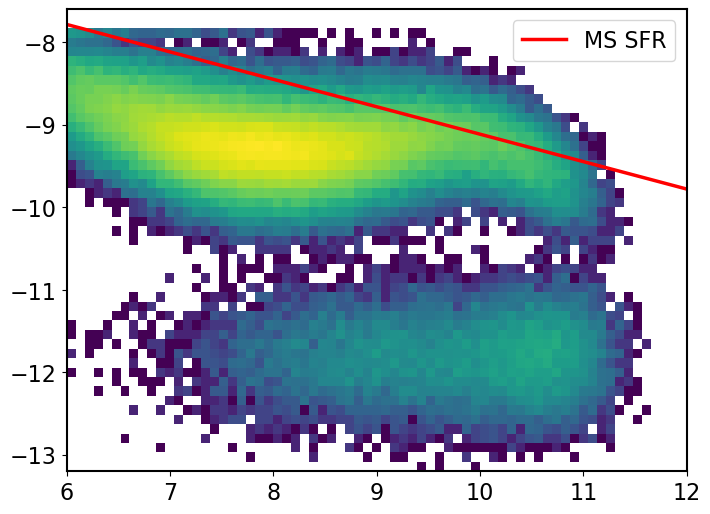

In [16]:
xbins = np.linspace(6, 12, 70)
ybins = np.linspace(-13.2, -7.6, 50)
from matplotlib.colors import LogNorm

inds = LC_CO.halo_catalog_all['SM_HALO']>0
ssfr = np.log10(LC_CO.halo_catalog_all['SFR_HALO'][inds]/LC_CO.halo_catalog_all['SM_HALO'][inds])

plt.hist2d(np.log10(LC_CO.halo_catalog_all['SM_HALO'][inds]),  y=ssfr,
          bins = [xbins,ybins], norm=LogNorm());

plt.plot(xbins, analytic_msssfr(10**xbins,0.9), color='r', label='MS SFR')
plt.legend()


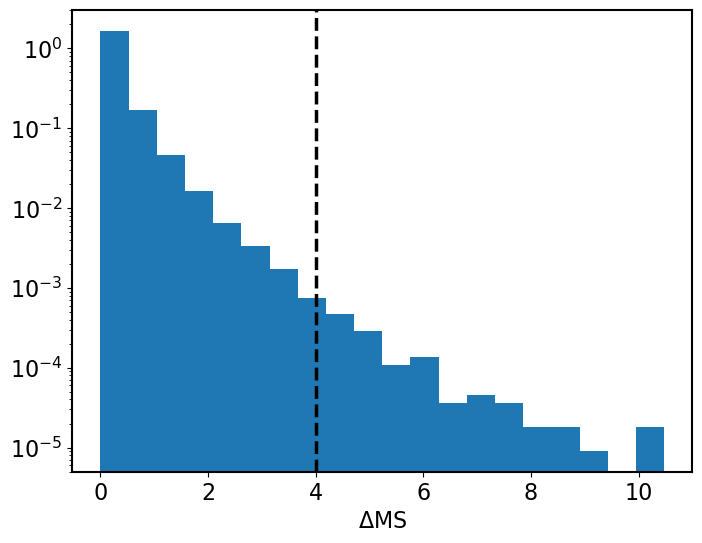

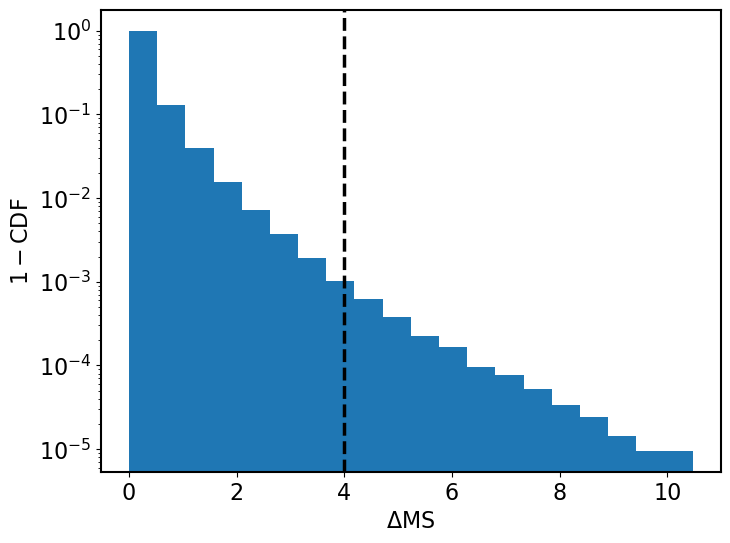

In [17]:
plt.hist(10**ssfr / 10**analytic_msssfr(LC_CO.halo_catalog_all['SM_HALO'][inds],0.9),bins=20,density=True)
plt.semilogy()
plt.xlabel(r'$\Delta {\rm MS}$')
plt.axvline(4,c='k',ls='--')
plt.show()
plt.hist(10**ssfr / 10**analytic_msssfr(LC_CO.halo_catalog_all['SM_HALO'][inds],0.9),bins=20,density=True,cumulative=-1)
plt.xlabel(r'$\Delta {\rm MS}$')
plt.axvline(4,c='k',ls='--')
plt.semilogy()
plt.ylabel(r'$1-{\rm CDF}$')
plt.show()

Text(0.5, 0, '$\\log_{10}(M_{\\rm dust}/M_*)$ [arbitrary amplitude]')

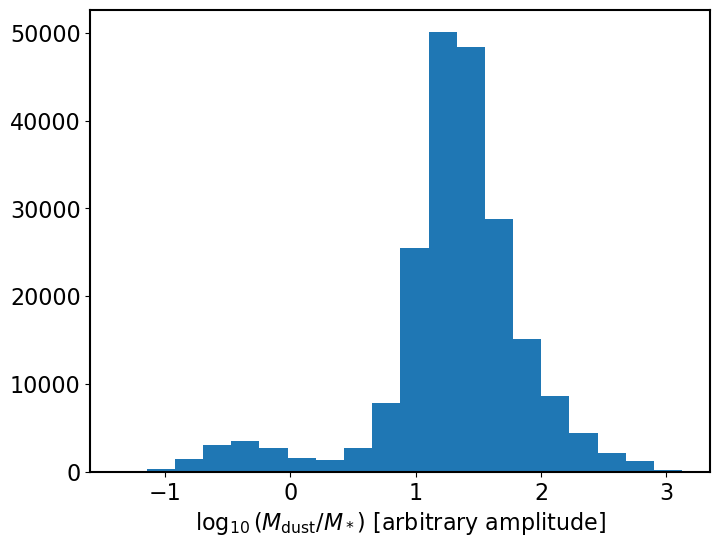

In [18]:
inds = LC_CO.halo_catalog_all['SM_HALO']>0
plt.hist(np.log10(mdust[inds]/LC_CO.halo_catalog_all['SM_HALO'][inds]),bins=20)
plt.xlabel(r'$\log_{10}(M_{\rm dust}/M_*)$ [arbitrary amplitude]')

In [19]:
import time

3.871026039123535


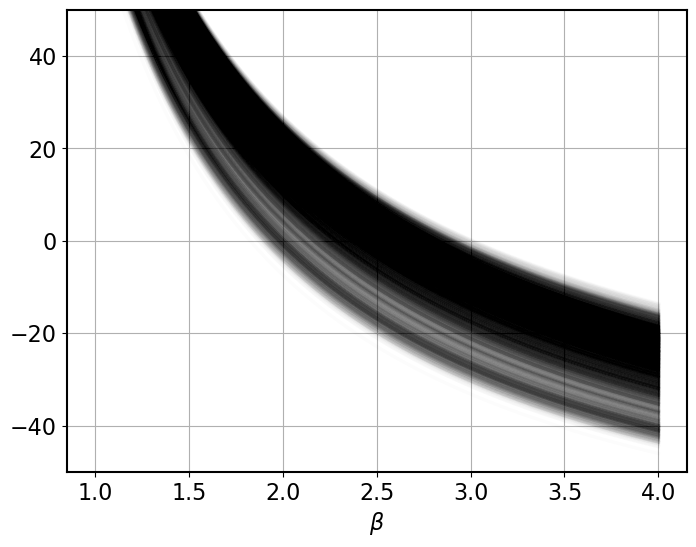

In [28]:
inds = mdust>0

start = time.time()
betavec = np.linspace(1, 4, 1000)
for i in range(5000):
    plt.plot(betavec, efe(betavec, LIRvec[inds][i].value,(mdust[inds])[i]), color='k', alpha=0.01)
# plt.ylim(0, 5020)
plt.ylim(-50, 50)
plt.grid()
# plt.xlim(0, 1)
# plt.legend()
plt.xlabel(r'$\beta$')
end = time.time()
print(end-start)

In [25]:
start = time.time()
beta_d = my_newton(LIRvec[inds].value,mdust[inds],2.5,Niter=5)
end = time.time()
print(end-start)


0.0235593318939209


Text(0.5, 0, '$T_{\\rm dust}\\,[K]$')

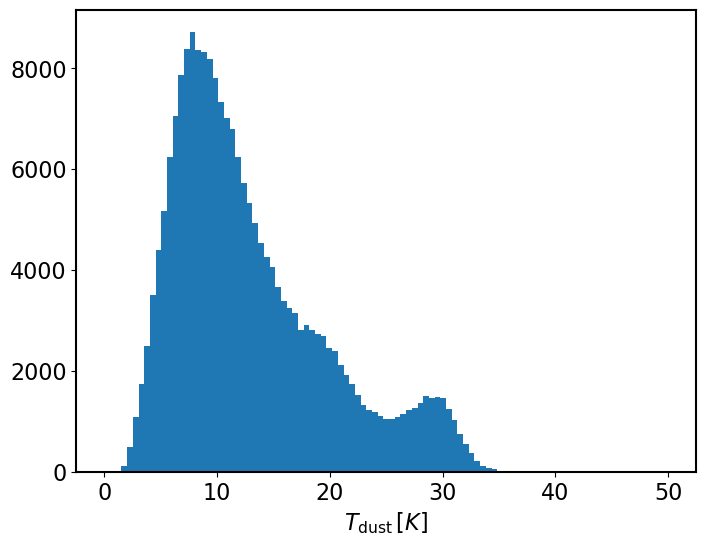

In [26]:
bins = np.linspace(0, 50, 100)
Ad = 33.96
dustvec = Ad * (LIRvec[inds].value/mdust[inds])**(1/(4+beta_d))
plt.hist(dustvec, bins=bins)
plt.xlabel(r'$T_{\rm dust}\,[K]$')

In [36]:
logMs = np.array([9.5,10,10.5,11,11.5])
for i in range(len(logMs)-1):
    inds_ms = (LC_CO.halo_catalog_all['SM_HALO']>=10**logMs[i])&(LC_CO.halo_catalog_all['SM_HALO']<10**logMs[i+1])
    beta_d = my_newton(LIRvec[inds_ms].value,mdust[inds_ms],2.5,Niter=15)
    dustvec = Ad * (LIRvec[inds_ms].value/mdust[inds_ms])**(1/(4+beta_d))
    print(logMs[i],logMs[i+1], np.mean(mdust[inds_ms])/1e7,np.mean(dustvec))

9.5 10.0 4880.4179968 25.207085
10.0 10.5 8606.9788672 26.5071
10.5 11.0 10845.9106304 25.429462
11.0 11.5 9769.6120832 23.608788


$M_{\rm dust}$ is WAY off due to the non-normalization of our formalism, but $T_{\rm dust}$ (which is what we care for), it's almost spot on

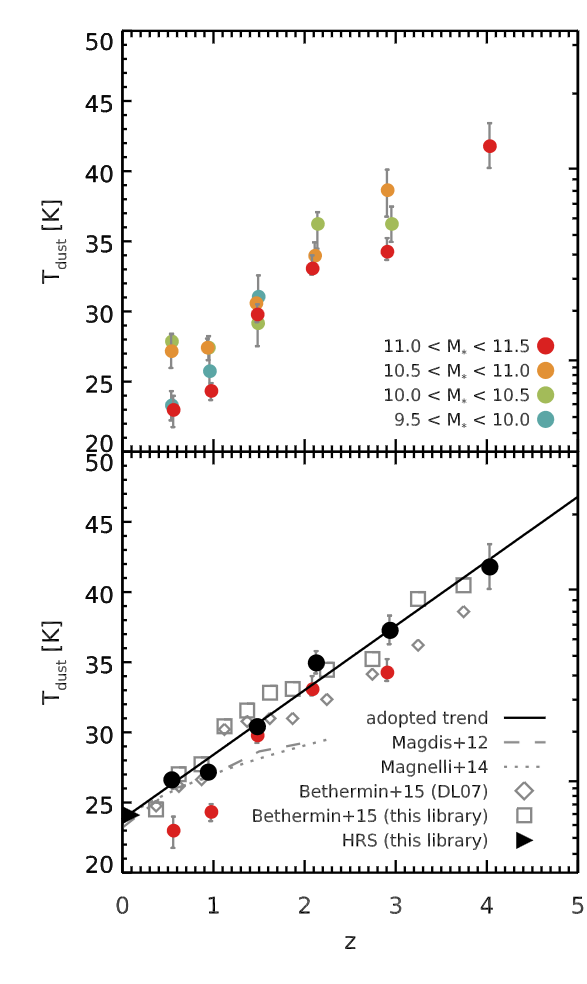
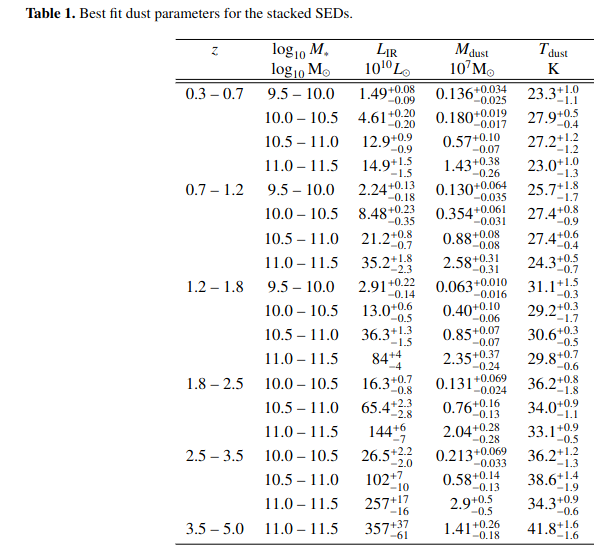

In [37]:
def SED(nu,Tdust,beta_d):
    alpha_d = 2
    nup = (cu.k_B*Tdust*u.K/(cu.h)).to(u.GHz)*(3+beta_d+alpha_d)
    Phi = np.zeros_like(nu.value)
    nulim = np.arange(len(nu))[nu>nup][0]
    Phi[:nulim] = nu[:nulim].value**(beta_d+3)/np.exp((cu.h*nu[:nulim]/cu.k_B/Tdust/u.K).decompose())
    Phi[nulim:] = nup.value**(beta_d+3)/np.exp((cu.h*nup/cu.k_B/Tdust/u.K).decompose())*(nu[nulim:]/nup)**-alpha_d
    return Phi

In [96]:
numax, numin = (cu.c/0.1/u.um).to(u.GHz), (cu.c/10000/u.um).to(u.GHz)
nu = np.logspace(0,8,10000)#np.logspace(np.log10(numin.value)-2,np.log10(numax.value),64)*u.GHz
sed = SED(nu*u.GHz,dustvec[100],beta_d[100])
nu2 = np.logspace(np.log10(numin.value)-2,np.log10(numax.value),1000)*u.GHz
sed2 = SED(nu2,dustvec[100],beta_d[100])

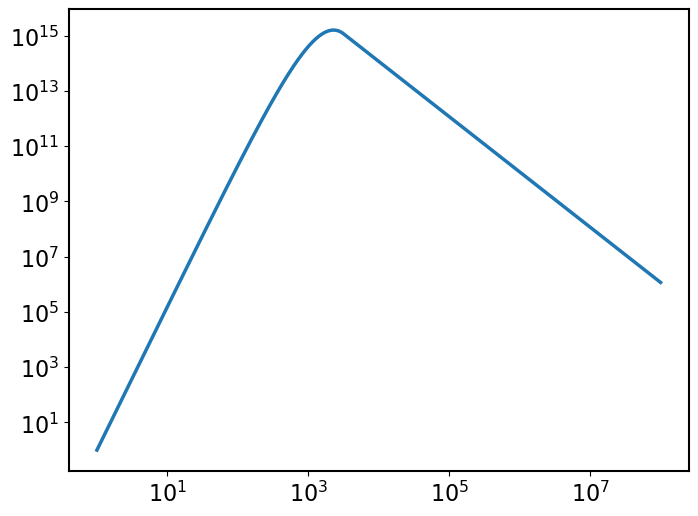

In [97]:
plt.loglog(nu,sed)

Done for all of them

In [12]:
Tdust,beta = SED_args(LC_CO.halo_catalog_all,LIRvec)

/tmp/ipykernel_40827/416112953.py:48: RuntimeWarning: divide by zero encountered in log10
  logmstar = np.log10(halocat['SM_HALO'])
/tmp/ipykernel_40827/416112953.py:70: RuntimeWarning: invalid value encountered in divide
  ssfr = halocat['SFR_HALO']/halocat['SM_HALO']
/tmp/ipykernel_40827/416112953.py:21: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(mstars) - 0.6 * np.log10(sfrs) - 10
/tmp/ipykernel_40827/416112953.py:21: RuntimeWarning: invalid value encountered in subtract
  y = np.log10(mstars) - 0.6 * np.log10(sfrs) - 10


In [13]:
inds = (LIRvec>0)
nu0 = np.logspace(2,np.log10(400),32)*u.GHz
nu = nu0[:,None]*(1+LC_CO.halo_catalog_all['Z'][inds])

In [14]:
import scipy.special as sp

In [15]:
sed = SED_array(nu,Tdust,beta)
norm = SEDnorm(Tdust,beta)

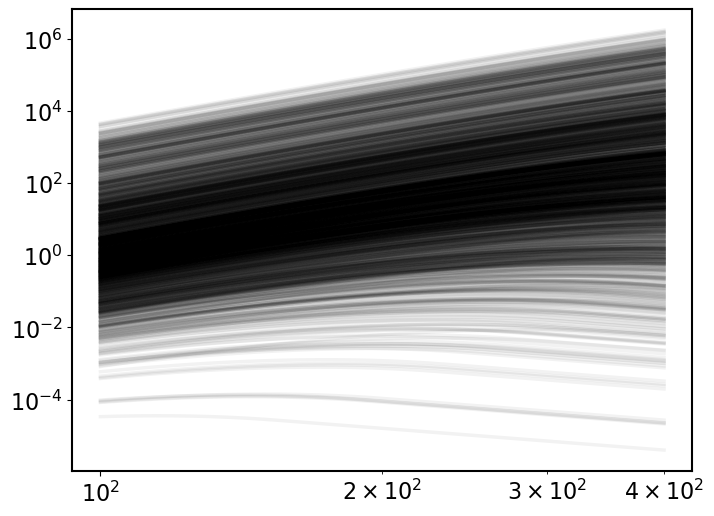

In [16]:
N = 100
for i in range(int(sed.shape[1]/N)):
    ic = int(N*i)
    plt.loglog(nu0,sed[:,ic]/norm[ic]*LIRvec[inds][ic],c='k',alpha=0.05)

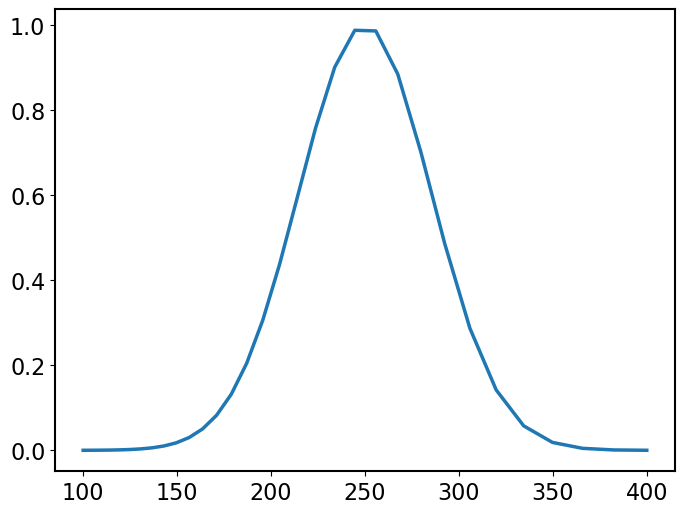

In [192]:
tau_nu = np.exp(-(nu0.value-0.5*(nu0.value[-1]+nu0.value[0]))**2/(50)**2)*u.GHz**-1
plt.plot(nu0,tau_nu)

In [193]:
Lnup = np.zeros_like(LIRvec)
Lnup[inds] = LIRvec[inds]*np.trapz(sed*tau_nu[:,None],nu0,axis=0)/norm*np.random.normal(1,0.25,len(norm))

/tmp/ipykernel_13378/43896239.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(Lnup[inds].value),bins=100)


Text(0.5, 0, '$L^{\\rm IR}_{\\nu(1+z)}$')

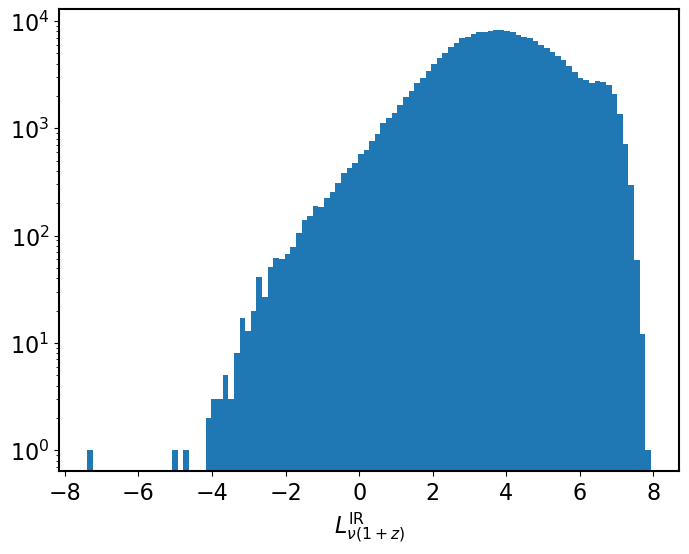

In [199]:
plt.hist(np.log10(Lnup[inds].value),bins=100)
plt.semilogy()
plt.xlabel(r'$L^{\rm IR}_{\nu(1+z)}$')